In [1]:

# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime

from pathlib import Path

current_dir = Path.cwd()
print("Current directory:", current_dir)


# Load all CSVs
claims = pd.read_csv('patient_claims_data.csv')
prescribers = pd.read_csv('prescriber_data.csv')
market = pd.read_csv('market_lookup_table.csv')
calendar = pd.read_csv('calendar_table.csv')

Current directory: D:\anusha_project


In [2]:

claims.head(5)




,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region
0,P23104,51904-9849,Drug_B,2022-05-12,2022-07-11,60,HCP3414,General,D654,East
1,P80678,29769-4788,Drug_D,2022-05-08,2022-06-07,30,HCP1400,General,D654,West
2,P13617,45614-6502,Drug_A,2024-02-19,2024-04-19,60,HCP7311,General,D789,East
3,P23577,29769-4788,Drug_D,2024-05-08,2024-08-06,90,HCP5499,General,D321,South
4,P44718,20561-3267,Drug_C,2024-06-11,2024-08-10,60,HCP1727,General,D789,West


In [3]:
prescribers.head(5)


,hcp_id,specialty,brand_written,region
0,HCP7311,Endocrinology,Drug_E,South
1,HCP4114,General,Drug_E,South
2,HCP5173,Neurology,Drug_E,East
3,HCP1727,Neurology,Drug_E,West
4,HCP8144,Cardiology,Drug_C,North


In [4]:

market.head(5)


,brand_name,molecule,therapeutic_class
0,Drug_A,Molecule_0,Class_A
1,Drug_B,Molecule_1,Class_B
2,Drug_C,Molecule_2,Class_C
3,Drug_D,Molecule_3,Class_A
4,Drug_E,Molecule_4,Class_B


In [5]:

calendar.head(5)

,date,month,year,fiscal_quarter,fiscal_year
0,2022-01-01,1,2022,1,2022
1,2022-01-02,1,2022,1,2022
2,2022-01-03,1,2022,1,2022
3,2022-01-04,1,2022,1,2022
4,2022-01-05,1,2022,1,2022


In [6]:
# Convert 'start_date' to datetime format for date calculations
claims['start_date'] = pd.to_datetime(claims['start_date'])

# Sort claims by patient and claim start date to maintain chronological order
claims = claims.sort_values(['patient_id', 'start_date'])

# Get the previous claim's end date for each patient
claims['prev_end'] = claims.groupby('patient_id')['end_date'].shift(1)

# Calculate the gap in days between the current claim's start and the previous claim's end
claims['gap'] = (claims['start_date'] - pd.to_datetime(claims['prev_end'])).dt.days

# Flag claims that start after a gap of more than 180 days — indicating a "new start"
claims['new_start'] = claims['gap'] > 180

# ----------------------------
# Discontinuation Detection
# ----------------------------

# Find the last fill (latest end_date) for each patient
last_fill = claims.groupby('patient_id')['end_date'].max().reset_index()

# Flag patients as discontinued if it's been more than 60 days since their last fill
last_fill['discontinued'] = (
    pd.to_datetime('today') - pd.to_datetime(last_fill['end_date'])
).dt.days > 60

# ----------------------------
# Molecule Switch Detection
# ----------------------------

# Merge claims with the 'market' dataset to associate each drug with its molecule
claims = pd.merge(claims, market, left_on='drug_name', right_on='brand_name', how='left')

# Detect if the molecule has changed from the previous claim — flag as molecule switch
# Compares current molecule with the one from the previous claim per patient
claims['molecule_switch'] = (
    claims.groupby('patient_id')['molecule'].shift(1) != claims['molecule']
)

# Show the first 5 rows of the modified DataFrame
claims.head(5)


,patient_id,ndc_code,drug_name,start_date,end_date,days_supply,provider_id,specialty,diagnosis_code,region,prev_end,gap,new_start,brand_name,molecule,therapeutic_class,molecule_switch
0,P10074,20561-3267,Drug_C,2022-04-06,2022-07-05,90,HCP8043,General,D654,South,NaN,NaN,False,Drug_C,Molecule_2,Class_C,True
1,P10074,29769-4788,Drug_D,2022-06-26,2022-09-24,90,HCP7790,General,D123,North,2022-07-05,-9.0,False,Drug_D,Molecule_3,Class_A,True
2,P10074,51904-9849,Drug_B,2022-07-29,2022-08-28,30,HCP6344,General,D456,South,2022-09-24,-57.0,False,Drug_B,Molecule_1,Class_B,True
3,P10074,60205-3503,Drug_E,2022-11-23,2023-02-21,90,HCP6067,General,D321,South,2022-08-28,87.0,False,Drug_E,Molecule_4,Class_B,True
4,P10074,20561-3267,Drug_C,2023-08-21,2023-11-19,90,HCP1090,General,D123,East,2023-02-21,181.0,True,Drug_C,Molecule_2,Class_C,True


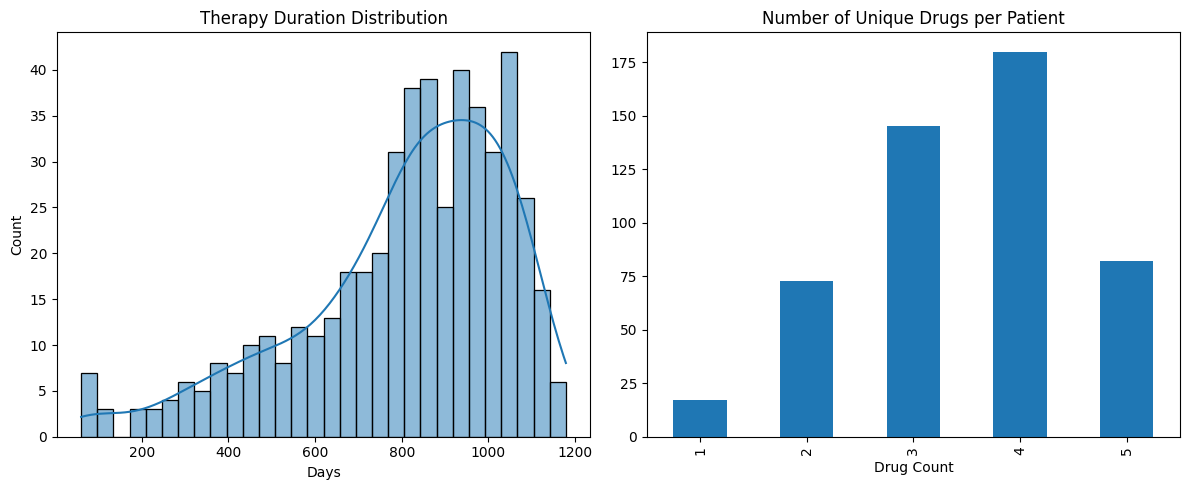

<Axes: xlabel='therapy_duration', ylabel='Count'>

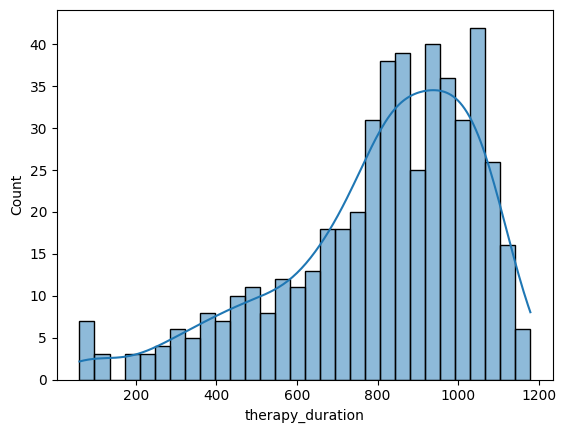

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_patient_funnel(claims):
    # Ensure 'start_date' and 'end_date' columns are in datetime format
    claims['start_date'] = pd.to_datetime(claims['start_date'])
    claims['end_date'] = pd.to_datetime(claims['end_date'])

    # Group by patient and calculate funnel metrics
    funnel = claims.groupby('patient_id').agg(
        initiated=('start_date', 'min'),       # First recorded claim (start of therapy)
        last_fill=('end_date', 'max'),         # Last recorded claim (end of therapy)
        unique_drugs=('drug_name', 'nunique'), # Number of distinct drugs the patient was prescribed
        total_rx=('ndc_code', 'count')         # Total number of prescriptions (NDC codes) filled
    ).reset_index()

    # Calculate duration of therapy in days
    funnel['therapy_duration'] = (funnel['last_fill'] - funnel['initiated']).dt.days

    # Plotting two visualizations side by side
    plt.figure(figsize=(12, 5))

    # Histogram of therapy durations
    plt.subplot(1, 2, 1)
    sns.histplot(funnel['therapy_duration'], bins=30, kde=True)
    plt.title('Therapy Duration Distribution')
    plt.xlabel('Days')

    # Bar chart of number of unique drugs per patient
    plt.subplot(1, 2, 2)
    funnel['unique_drugs'].value_counts().sort_index().plot(kind='bar')
    plt.title('Number of Unique Drugs per Patient')
    plt.xlabel('Drug Count')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

    return funnel

# Run the funnel analysis and generate plots
funnel = create_patient_funnel(claims)

# (Redundant re-calculation below - could be removed)
# Recalculate patient funnel data again (already done above)
funnel = claims.groupby('patient_id').agg(
    initiated=('start_date', 'min'),
    last_fill=('end_date', 'max'),
    unique_drugs=('drug_name', 'nunique')
).reset_index()

# Recalculate therapy duration
funnel['therapy_duration'] = (funnel['last_fill'] - funnel['initiated']).dt.days

# Plot therapy duration distribution again
import seaborn as sns
sns.histplot(funnel['therapy_duration'], bins=30, kde=True)


In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt


In [9]:
# Merge claims with prescriber details using provider/hcp IDs
df = pd.merge(claims, prescribers, left_on='provider_id', right_on='hcp_id', how='left')

# Ensure calendar date is in datetime format
calendar['date'] = pd.to_datetime(calendar['date'])

# Merge calendar data with the claims dataframe based on the start date of prescription
df = pd.merge(df, calendar, left_on='start_date', right_on='date', how='left')


In [10]:
# Create patient-level quarterly features
features = df.groupby(['patient_id', 'fiscal_quarter']).agg(
    fills=('ndc_code', 'count'),                         # Total number of prescriptions in the quarter
    adherence=('days_supply', lambda x: x.sum() / 90),   # Proportion of Days Covered (PDC) — rough adherence metric
    gap_days=('gap', 'mean'),                            # Average days between prescriptions
    hcp_specialty=('specialty_y', 'first'),              # Prescriber's specialty (take first occurrence)
    region=('region_x', 'first')                         # Patient or provider region
).reset_index()


In [11]:
# Group data by month and count total prescriptions
monthly_rx = (df.groupby(pd.to_datetime(df['start_date']))['ndc_code']
              .count()
              .resample('ME')       # 'ME' = month-end
              .sum()
              .reset_index())

# Rename columns for Prophet compatibility
monthly_rx.columns = ['ds', 'y']


22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing


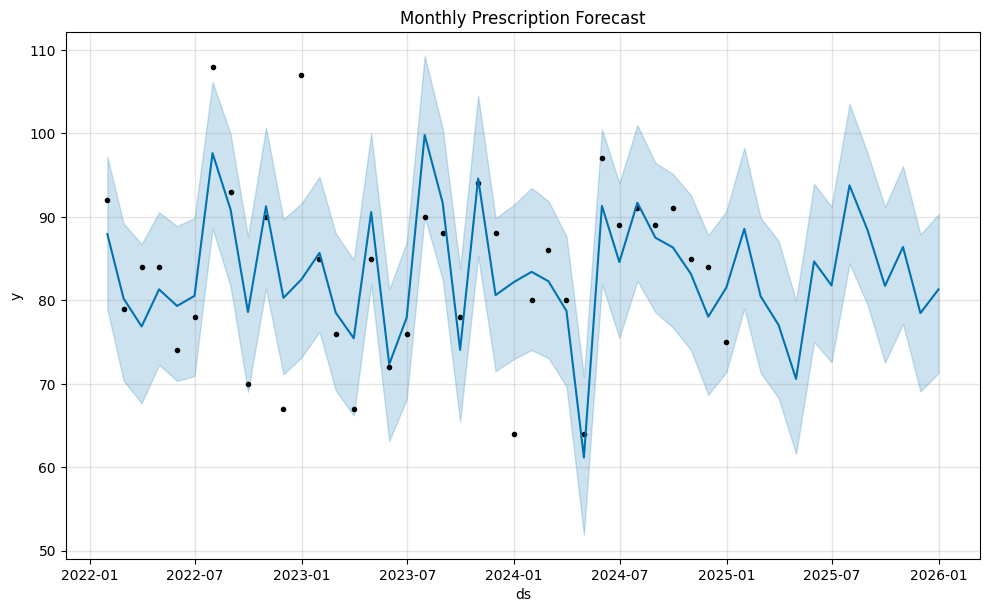

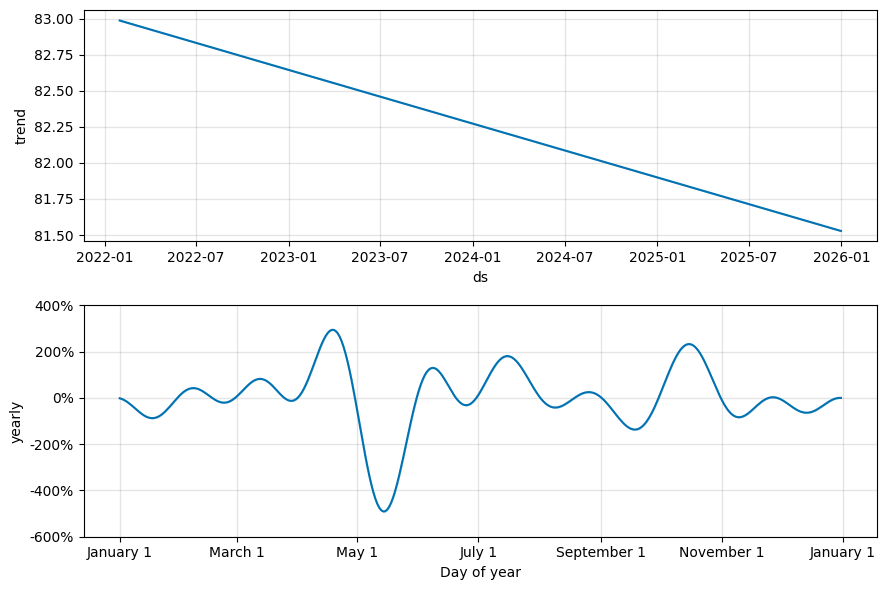

In [12]:
# Initialize Prophet model with multiplicative seasonality (good for percentage changes)
model = Prophet(seasonality_mode='multiplicative')
model.fit(monthly_rx)  # Fit the model to historical data

# Create a future dataframe with 12 months ahead
future = model.make_future_dataframe(periods=12, freq='ME')

# Generate predictions for future dates
forecast = model.predict(future)

# Plot forecast (actuals + predictions)
fig = model.plot(forecast)
plt.title('Monthly Prescription Forecast')
plt.show()

# Plot Prophet components (seasonality, trend, holidays)
fig2 = model.plot_components(forecast)
plt.show()


In [13]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Keep a copy of original features
features_original = features.copy()
features_processed = features.copy()

# Create binary target: whether the patient will have any fills next quarter
features_processed['target'] = features_processed.groupby('patient_id')['fills'].shift(-1) > 0

# Drop rows with NaNs (i.e., last quarter for each patient where shift(-1) has no future data)
features_processed_2 = features_processed.dropna()

# One-hot encode categorical variables (hcp_specialty, region) for model input
X = pd.get_dummies(features_processed_2.drop(['target', 'patient_id'], axis=1),
                   columns=['hcp_specialty', 'region'])

# Target variable
y = features_processed_2['target']

# Split data into training and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost classification model to predict if patient will continue filling meds
model = XGBClassifier(enable_categorical=False)  # Turn off native categorical encoding
model.fit(X_train, y_train)  # Fit model

print("Model trained successfully!")


Model trained successfully!


In [14]:
features_processed_2.head(10)
X.head(5)

,fiscal_quarter,fills,adherence,gap_days,hcp_specialty_Cardiology,hcp_specialty_Endocrinology,hcp_specialty_General,hcp_specialty_Neurology,region_East,region_North,region_South,region_West
0,2,4,3.000000,59.333333,False,True,False,False,False,False,True,False
1,3,4,2.000000,32.750000,False,False,True,False,False,False,True,False
2,4,2,1.333333,20.500000,False,False,True,False,False,False,True,False
3,2,2,1.333333,61.500000,False,False,False,True,False,False,False,True
4,3,2,1.333333,150.000000,False,True,False,False,False,False,True,False


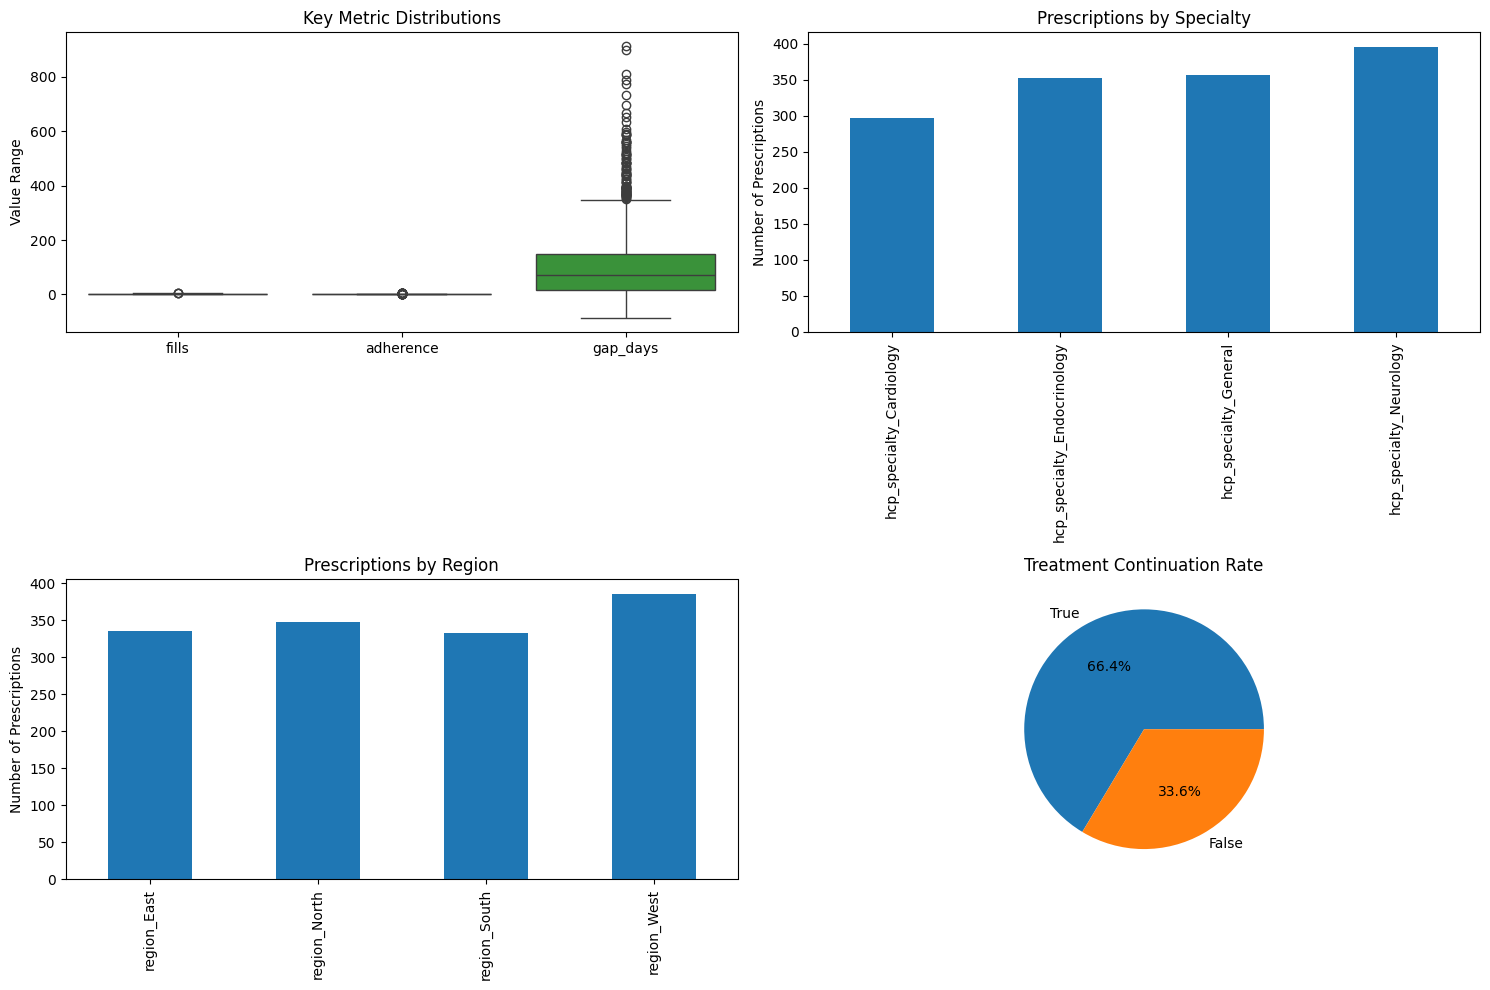

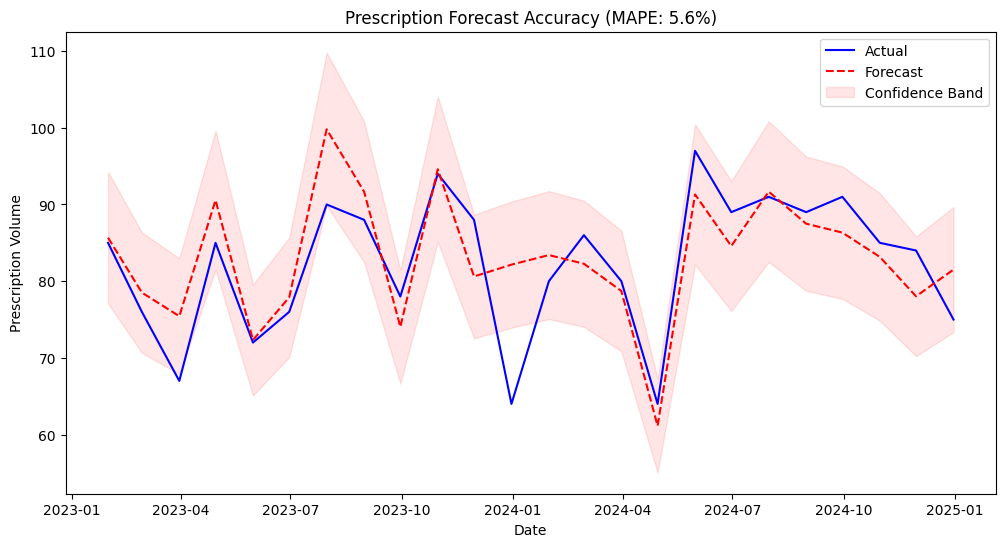

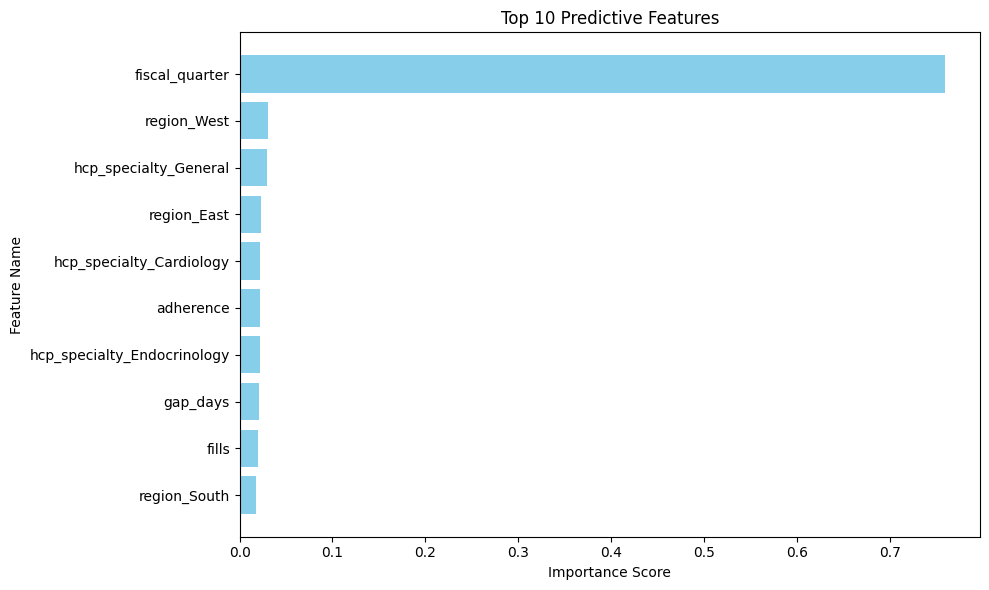

In [15]:
# Import visualization and math libraries
import matplotlib.pyplot as plt  # Base plotting library
import seaborn as sns            # Enhanced statistical visualizations
import numpy as np               # Numerical operations and math functions

# ==================================================================
# DATA PREPARATION SECTION
# ==================================================================

# Merge actual prescription data with forecasted values
# - Filters monthly_rx to only include dates after Jan 2023
# - Joins with forecast predictions (yhat) on date column (ds)
pred_vs_actual = pd.merge(
    monthly_rx[monthly_rx['ds'] > '2023-01-01'],  # Actual values post-Jan 2023
    forecast[['ds', 'yhat']],                     # Forecast predictions
    on='ds'                                       # Join on date column
)

# Calculate Mean Absolute Percentage Error (MAPE)
# - Measures forecast accuracy as percentage error
# - Formula: average of (|actual - predicted| / actual)
mape = np.mean(np.abs(pred_vs_actual['y'] - pred_vs_actual['yhat']) / pred_vs_actual['y'])

# Get indices that would sort feature importance scores
# - argsort() returns indices from least to most important
# - Will use later to plot top features
sorted_idx = model.feature_importances_.argsort()

# ==================================================================
# VISUALIZATION SECTION
# ==================================================================

# 1. FEATURE DISTRIBUTIONS PLOT (4-in-1 layout)
plt.figure(figsize=(15,10))  # Create 15x10 inch figure

# Subplot 1: Boxplots of numerical features
plt.subplot(2,2,1)  # 2x2 grid, position 1
sns.boxplot(data=X[['fills','adherence','gap_days']])  # Distribution visualization
plt.title('Key Metric Distributions')  # Shows median, quartiles and outliers
plt.ylabel('Value Range')  # Y-axis label

# Subplot 2: Specialty distribution
plt.subplot(2,2,2)  # Position 2
X.filter(like='hcp_specialty_').sum().plot(kind='bar')  # Sum one-hot encoded columns
plt.title('Prescriptions by Specialty')  # Which specialties prescribe most
plt.ylabel('Number of Prescriptions')

# Subplot 3: Regional distribution
plt.subplot(2,2,3)  # Position 3
X.filter(like='region_').sum().plot(kind='bar')  # Sum regional one-hot columns
plt.title('Prescriptions by Region')  # Geographic distribution
plt.ylabel('Number of Prescriptions')

# Subplot 4: Target class balance
plt.subplot(2,2,4)  # Position 4
y.value_counts().plot(kind='pie', autopct='%1.1f%%')  # Show percentage distribution
plt.title('Treatment Continuation Rate')  # % of patients continuing treatment
plt.ylabel('')  # Remove default y-label

plt.tight_layout()  # Prevent label overlapping
plt.show()  # Display the figure

# 2. FORECAST ACCURACY PLOT
plt.figure(figsize=(12,6))  # New 12x6 inch figure

# Plot actual prescription values as blue line
plt.plot(pred_vs_actual['ds'], pred_vs_actual['y'], 'b-', label='Actual')

# Plot forecasted values as red dashed line
plt.plot(pred_vs_actual['ds'], pred_vs_actual['yhat'], 'r--', label='Forecast')

# Add confidence band (90-110% of forecast)
plt.fill_between(pred_vs_actual['ds'],
                pred_vs_actual['yhat']*0.9,  # Lower bound
                pred_vs_actual['yhat']*1.1,  # Upper bound
                color='r', alpha=0.1, label='Confidence Band')  # Semi-transparent red

# Add title with MAPE score formatted as percentage
plt.title(f'Prescription Forecast Accuracy (MAPE: {mape:.1%})')
plt.xlabel('Date')  # X-axis label
plt.ylabel('Prescription Volume')  # Y-axis label
plt.legend()  # Show line labels
plt.show()  # Display plot

# 3. FEATURE IMPORTANCE PLOT
plt.figure(figsize=(10,6))  # New 10x6 inch figure

# Horizontal bar plot of top 10 important features
# [sorted_idx][-10:] gets indices of top 10 features
plt.barh(X.columns[sorted_idx][-10:],        # Feature names on Y-axis
        model.feature_importances_[sorted_idx][-10:],  # Importance scores on X
        color='skyblue')  # Bar color

plt.title('Top 10 Predictive Features')  # Chart title
plt.xlabel('Importance Score')  # X-axis label
plt.ylabel('Feature Name')  # Y-axis label
plt.tight_layout()  # Adjust spacing
plt.show()  # Display plot